<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/EfficienctNetV2B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [1]:
!pip install --upgrade pip
!pip install tensorflow-datasets
!pip install tensorflow_data_validation[visualization]==1.8.0 tensorflow==2.8
!pip install keract
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 9.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.3/668.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 

In [1]:
# tf/keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.model_selection import KFold, StratifiedKFold

# utlity
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


%load_ext tensorboard

##1.2 Check connection to GPU and drive

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##1.3 Declare constant variables

In [4]:
IMG_SIZE = 224
NUM_BREEDS = 120
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENV2B0'

#**2. Load dataset**

#2.1 Load and visualise data

In [5]:
(train, val, test), info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True, # tuple instead of dictionary
                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteORORC5/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteORORC5/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
class_labels = info.features['label'].int2str

print('Number of classes: ', info.features['label'].num_classes)
print()
print('Number of samples:')
print('Training set: ', len(train))
print('Validation set: ', len(val))
print('Testing set: ', len(test))
print()
print(info)

Number of classes:  120

Number of samples:
Training set:  16464
Validation set:  2058
Testing set:  2058

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
      

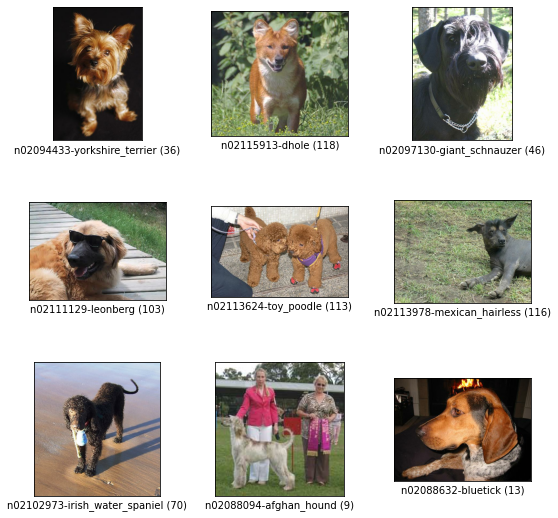

In [7]:
fig = tfds.show_examples(train, info)

#2.2 Retrieve breed list

In [ ]:
breed_list = []

for filename in info.features['label'].names:
  separator = [i for i, letter in enumerate(filename) if letter == '-']
  breed_list.append(filename[separator[0]+1:])

print(breed_list)

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

##2.3 Visualise dataset distributions

In [ ]:
train_labels, train_counts = np.unique(np.fromiter(train.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Training set class distribution")
sns.barplot(x = train_counts, y = train_labels, orient='h') 

In [ ]:
val_labels, val_counts = np.unique(np.fromiter(val.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = val_counts, y = val_labels, orient='h') 

In [ ]:
test_labels, test_counts = np.unique(np.fromiter(test.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = test_counts, y = test_labels, orient='h') 

#**3. Modelling**

##3.1 Preprocessing Layers

In [30]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
RANDOM_SEED = 43

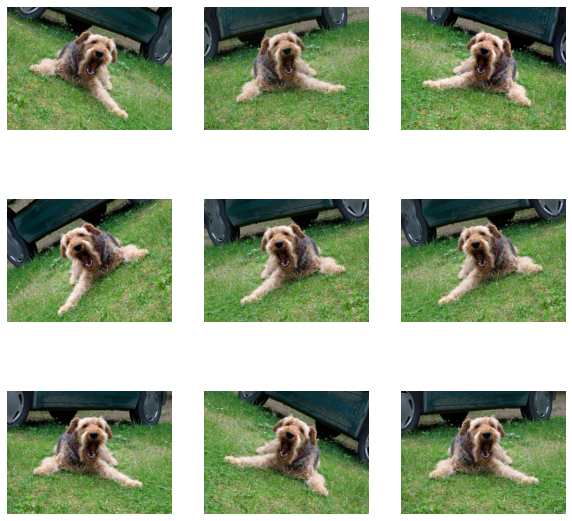

In [9]:
img_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(factor=0.1),
                                        ])

# Visualize some augmentations
ex_img, label = next(iter(train))
ex_img = tf.cast(ex_img, tf.float32) / 255.

img_batch = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_img = img_augmentation(img_batch, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_img[0])
  plt.axis("off")

In [10]:
# Efficientnet takes input images of shape (224, 224, 3) with range [0,255] --> normalisation not needed
# reference: https://keras.io/api/applications/efficientnet/#efficientnetb0-function

def one_hot(image, label):
  label = tf.one_hot(label,NUM_BREEDS)
  return image, label

def resize(image, label):
  image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
  # image = tf.cast(image, tf.float32) / 255.
  return image, label

def preprocess(image, label):
  return tf.keras.applications.efficientnet_v2.preprocess_input(tf.cast(image, tf.float32)), label

# Resize and one-hot encode all datasets

ds_train = train.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = val.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = test.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [11]:
def create_model():
  inputs = Input(shape=INPUT_SHAPE)
  x = img_augmentation(inputs)
  ENB0_base = tf.keras.applications.EfficientNetV2B0(input_tensor=x,
                                                input_shape=INPUT_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  ENB0_base.trainable = False
  x = GlobalAveragePooling2D()(base.output)
  x = layers.BatchNormalization()(x)
  x = Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(RANDOM_SEED), bias_initializer='zeros')(x)
  x = layers.BatchNormalization()(x)
  outputs = Dense(NUM_BREEDS, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return Model(inputs=inputs, outputs=outputs, name='MNV2')

In [12]:
ENB0_model = create_model()
ENB0_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ENB0_model.summary()

24289280/24274472 [==============================] - 0s 0us/step
Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['sequential[0][0]']             
                              

In [13]:
EPOCHS = 45
CP_PATH = CP_DIR+'/FE/ENV2B0-{epoch:02d}.h5'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ENB0_history = ENB0_model.fit(ds_train, 
                    epochs=EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

# save the model if results are satisfactory
ENB0_model.save(CP_PATH+'/model/ENV2B0.h5')

Epoch 1/45
257/257 [==============================] - 61s 123ms/step - loss: 1.8134 - accuracy: 0.6943 - top_k_categorical_accuracy: 0.9151 - val_loss: 0.6553 - val_accuracy: 0.8037 - val_top_k_categorical_accuracy: 0.9741
Epoch 2/45
257/257 [==============================] - 21s 80ms/step - loss: 0.6237 - accuracy: 0.8161 - top_k_categorical_accuracy: 0.9788 - val_loss: 0.5175 - val_accuracy: 0.8501 - val_top_k_categorical_accuracy: 0.9854
Epoch 3/45
257/257 [==============================] - 19s 74ms/step - loss: 0.4996 - accuracy: 0.8462 - top_k_categorical_accuracy: 0.9867 - val_loss: 0.5848 - val_accuracy: 0.8398 - val_top_k_categorical_accuracy: 0.9834
Epoch 4/45
257/257 [==============================] - 19s 73ms/step - loss: 0.4521 - accuracy: 0.8593 - top_k_categorical_accuracy: 0.9905 - val_loss: 0.6295 - val_accuracy: 0.8291 - val_top_k_categorical_accuracy: 0.9834
Epoch 5/45
257/257 [==============================] - 19s 73ms/step - loss: 0.4269 - accuracy: 0.8667 - top_k_c

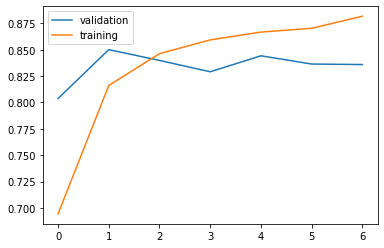

In [16]:
plt.plot(ENB0_history.history['val_accuracy'], label='validation')
plt.plot(ENB0_history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [27]:
logname = CP_DIR + '/FE.csv'

df_fe_history = pd.DataFrame.from_dict(ENB0_history.history) 
df_fe_history.to_csv(logname, index = False, header=True)

Finetuning

In [ ]:
def print_trainable(model):
  for layer_id, layer in enumerate(model.layers):
    print(layer_id,' ' , layer.name, ": ", layer.trainable)

In [21]:
ft_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENV2B0/FE/ENV2B0-02.h5')

def unfreeze(model, start_layer, end_layer):
  for layer_id, layer in enumerate(model.layers):
    if layer_id >= start_layer and layer_id <= end_layer:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

unfreeze(ft_model, 0, len(ft_model.layers)-1)

In [ ]:
print_trainable(ft_model)

0   input_2 :  False
1   sequential :  False
2   rescaling_1 :  False
3   normalization_1 :  False
4   stem_conv :  False
5   stem_bn :  False
6   stem_activation :  False
7   block1a_project_conv :  False
8   block1a_project_bn :  False
9   block1a_project_activation :  False
10   block2a_expand_conv :  False
11   block2a_expand_bn :  False
12   block2a_expand_activation :  False
13   block2a_project_conv :  False
14   block2a_project_bn :  False
15   block2b_expand_conv :  False
16   block2b_expand_bn :  False
17   block2b_expand_activation :  False
18   block2b_project_conv :  False
19   block2b_project_bn :  False
20   block2b_add :  False
21   block3a_expand_conv :  False
22   block3a_expand_bn :  False
23   block3a_expand_activation :  False
24   block3a_project_conv :  False
25   block3a_project_bn :  False
26   block3b_expand_conv :  False
27   block3b_expand_bn :  False
28   block3b_expand_activation :  False
29   block3b_project_conv :  False
30   block3b_project_bn :  False


In [22]:
ft_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ft_model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                               

In [23]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

CP_PATH = CP_DIR+'/FT/ENV2B0-{epoch:02d}.h5'

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

FT_EPOCHS = 30
ft_history = ft_model.fit(ds_train, 
                    epochs=FT_EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

Epoch 1/30
257/257 [==============================] - 75s 249ms/step - loss: 0.3673 - accuracy: 0.8818 - top_k_categorical_accuracy: 0.9923 - val_loss: 0.4381 - val_accuracy: 0.8716 - val_top_k_categorical_accuracy: 0.9858
Epoch 2/30
257/257 [==============================] - 61s 239ms/step - loss: 0.2965 - accuracy: 0.9053 - top_k_categorical_accuracy: 0.9955 - val_loss: 0.4109 - val_accuracy: 0.8760 - val_top_k_categorical_accuracy: 0.9863
Epoch 3/30
257/257 [==============================] - 61s 235ms/step - loss: 0.2614 - accuracy: 0.9202 - top_k_categorical_accuracy: 0.9960 - val_loss: 0.4074 - val_accuracy: 0.8799 - val_top_k_categorical_accuracy: 0.9868
Epoch 4/30
257/257 [==============================] - 59s 231ms/step - loss: 0.2428 - accuracy: 0.9219 - top_k_categorical_accuracy: 0.9964 - val_loss: 0.3995 - val_accuracy: 0.8784 - val_top_k_categorical_accuracy: 0.9863
Epoch 5/30
257/257 [==============================] - 59s 230ms/step - loss: 0.2223 - accuracy: 0.9292 - top

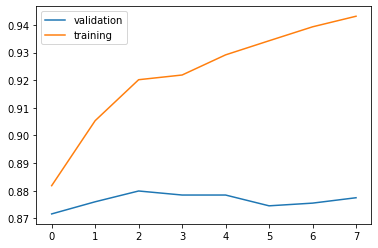

In [24]:
plt.plot(ft_history.history['val_accuracy'], label='validation')
plt.plot(ft_history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [26]:
logname = CP_DIR + '/FT.csv'

df_ft_history = pd.DataFrame.from_dict(ft_history.history) 
df_ft_history.to_csv(logname, index = False, header=True)

## 3.4 Testing

In [28]:
best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENV2B0/FT/ENV2B0-03.h5')

In [29]:
best_model.evaluate(ds_test)

32/32 [==============================] - 6s 137ms/step - loss: 0.4348 - accuracy: 0.8682 - top_k_categorical_accuracy: 0.9873


[0.43481871485710144, 0.8681640625, 0.9873046875]